In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

# Ejemplo 1: Sadiku, Problema 14.3

[[10. 10. 50.  0.  0.]
 [10.  0.  0. 50.  0.]
 [10.  0.  0.  0. 50.]
 [10.  0.  0. 50.  0.]
 [10. 10. 50.  0.  0.]]

[[10.       10.       50.        0.        0.      ]
 [10.        5.       26.25     50.        0.      ]
 [10.        3.75      7.5      39.375    50.      ]
 [10.        5.9375   28.359375 50.        0.      ]
 [10.       10.       50.        0.        0.      ]]

[[10.         10.         50.          0.          0.        ]
 [10.         12.5        30.         50.          0.        ]
 [10.          8.984375   26.6796875  44.16992188 50.        ]
 [10.         14.3359375  35.25390625 50.          0.        ]
 [10.         10.         50.          0.          0.        ]]

[[10.         10.         50.          0.          0.        ]
 [10.         14.74609375 35.35644531 50.          0.        ]
 [10.         16.44042969 32.80517578 45.70129395 50.        ]
 [10.         17.92358398 37.68218994 50.          0.        ]
 [10.         10.         50.          0.      

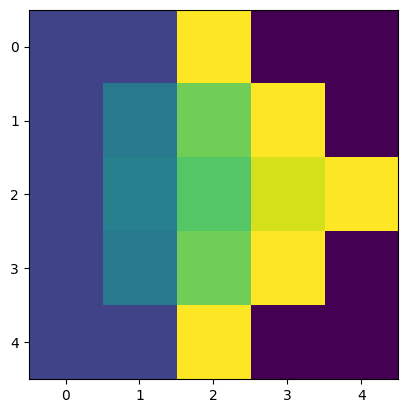

In [2]:
#Generamos una malla para definir más facilmente las condiciones de borde
yy, xx = np.mgrid[:5, :5]

#Condiciones de Borde
borde1 = 10.0 * ((xx < 1) + (yy < 1) * (xx < 2) + (yy > 3) * (xx < 2))
borde2 = 50.0 * (((xx - 2) == yy) * (xx > 1) + (yy == -xx + 6) * (xx > 1))
bordes = borde1 + borde2

#Nodos sobre los cuales vamos a iterar
nodes = ((xx > 0) * (xx < 3) * (yy > 0) * (yy < 4) + (xx==3)*(yy==2)) * 1.0

#Potencial electrico sobre el cual vamos a iterar
V = bordes

#Iteración
N = 10;                     #Numero de iteraciones
print(V)                    #Mostramos el estado inicial del sistema
for iter in range (0,N):    #Iteramos
  for i in range(0,5):
    for j in range(0,5):
      if  (nodes[i,j]) == 1:  #Solo cambiamos los nodos de interés
        V[i,j] = (V[i-1,j] + V[i+1,j] + V[i,j-1] + V[i,j+1])/4 #Diferencias Finitas
  print("")
  print(V)                  #Mostramos el valor actualizado

#Graficamos
plt.imshow(V)
plt.show()

#Problema 2: Diferencias Finitas para resolver la Ecuación de Onda

In [3]:
class DFDT_Onda(object):
  #Inicialización
  def __init__(self, freq = 300000000, E0 = 1, theta = 0,\
               epsr = 1, mur = 1, Nx = 200):
    #Constantes
    self.mu0 = 4 * np.pi * 10 ** (-7)               #Permeabilidad del vacío
    self.eps0 = 8.8542 * 10 ** (-12)                #Permitividaad del vacío
    self.c = 300 * 10 ** (6)                        #Velocidad de la luz en el vacío

    #Parámetros de la onda
    self.freq = freq                                #Frecuencia [Hz]
    self.E0 = E0                                    #Amplitud inicial de E
    self.theta = theta                              #Desfase [°]
    self.theta_rad = (self.theta * np.pi) / 180     #Desfase [rad]
    self.omega = 2 * np.pi * self.freq              #Frecuencia [rad]

    #Parámetros del medio
    self.mur = mur                                  #Permeabilidad relativa
    self.epsr = epsr                                #Permitividad relativa

    #Calculo de coeficientes y parámetros
    mu = self.mu0 * self.mur                        #Permeabilidad
    eps = self.eps0 * self.epsr                     #Permitividad
    self.beta  = self.omega * np.sqrt(mu * eps)     #Beta
    self.eta_mag = np.sqrt(mu / eps)                #Impedancia (magnitud)
    self.eta_phs = 0                                #Impedancia (fase)
    self.u = self.omega / self.beta                 #Velocidad de propagación

    #Parámetros físicos:
    #Con estos escogeremos una ventana espacial apropiada para la
    #simulación, de manera que podamos apreciar al menos 2 longitudes de onda.
    self.Nx = Nx                                    #Número de muestras
    self.lambda1 = 2 * np.pi / self.beta            #Longitud de onda
    self.dz = self.lambda1 / self.Nx                #Discretizamos en Nx puntos
    self.zz = np.arange(0, 2 * self.lambda1 + self.dz, self.dz) #Vector de z

    #En el caso del tiempo, no podemos escoger un dt arbitrario.
    #Debemos respetar la condición Courant–Friedrichs–Lewy
    #Esta nos dice que (u * dt / dx) debe ser muy cercana y menor a 1, a modo
    #de garantizar estabilidad en las soluciones

    self.T = self.lambda1 * np.sqrt(mu * eps)             #Periodo de onda
    self.dt = self.dz / (1 * self.u)                      #Escogemos dt adecuado
    self.tt = np.arange(0, 2 * self.T + self.dt, self.dt) #Vector de t para 2 periodos
    self.Ezt = np.zeros([len(self.zz),len(self.tt)])      #Matriz para guardar los frames

    #Condiciones iniciales
    self.Ezt[:,0] = 0    #Al instante 0 no hay nada

    #Condiciones de borde
    #Imponemos una onda que se acerca por la izquierda y desaparece por la
    #derecha
    self.Ezt[0,:] = self.E0 * np.cos(self.omega * self.tt + self.theta_rad)
    self.Ezt[-1,:] = 0


  #Ejecutamos diferencias finitas
  def run(self, iters = 1000):      #Dejemos como entrada las iteraciones ;)

    #El factor alfa visto en clases, para formular diferencias finitas
    alpha = (self.u * self.dt / self.dz) ** 2

    #Para cada iteracion
    for i in range(0,iters):
      for z in range(1,len(self.zz)-1):
        # 1 frame = todo el espacio en un tiempo t
        for t in range(1,len(self.tt)-1):
          #Planteamos diferencias finitas
          self.Ezt[z,t+1] = alpha * (self.Ezt[z+1,t] + self.Ezt[z-1,t])\
                            + 2 * (1 - alpha) * self.Ezt[z,t] - self.Ezt[z,t-1]

  def plot(self, i = 20):
    fig = plt.figure(figsize = (10, 5))                           #Instanciamos figura
    plt.plot(self.zz, self.Ezt[:,i], color = "r", linewidth = 2)  #Ploteamos un frame de E
    plt.xlabel("Z")                                               #Label del "Eje z"
    plt.grid(True)                                                #Añadir grilla
    plt.title("Onda Eléctrica simple")                            #Título
    plt.show()

  def animate(self,  file_dir = "Onda_FDTD.gif", N = 400):
    Ezt = self.Ezt[:,-N:]                                 #Tomamos los ultimos N frames

    #Le damos formato a la gráfica de la animación
    fig, ax = plt.subplots()                              #Instanciamos figura
    ax.set(xlim=[0, 2], ylim=[-1, 1])                     #Acomodamos los ejes
    line = ax.plot(self.zz, self.Ezt[:,0], color = "r", linewidth = 2)[0] #Instanciamos la primera gráfica
    plt.xlabel("Z")                                       #Label del "Eje z"
    plt.grid(True)                                        #Añadir grilla
    plt.title("Onda Eléctrica simple")                    #Título

    #Función para generar la animación a partir de los frames
    def animate(i):
      line.set_ydata(Ezt[:,i])                            #Actualizamos el frame

    #Generamos la animación
    anim = FuncAnimation(fig, animate, interval = 50, frames = len(self.zz) - 1)
    anim.save(file_dir, writer = "pillow")

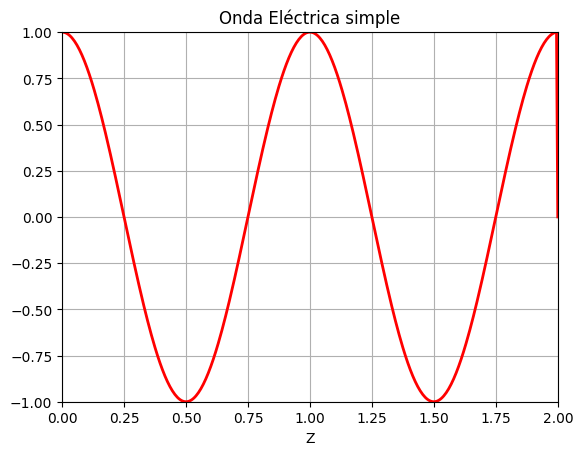

In [4]:
DFDT = DFDT_Onda()
DFDT.run(iters = 1000)
#DFDT.plot(300)
DFDT.animate()

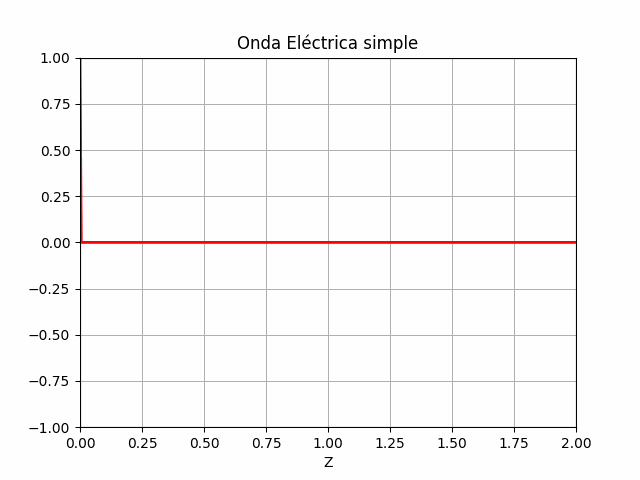

In [7]:
Image(open('/content/Onda_FDTD.gif', 'rb').read())